In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/subjectivity-detection-splitted/Split 70/test.xlsx
/kaggle/input/subjectivity-detection-splitted/Split 70/train.xlsx
/kaggle/input/subjectivity-detection-splitted/Split 70/val.xlsx
/kaggle/input/subjectivity-detection-splitted/Split80/test.xlsx
/kaggle/input/subjectivity-detection-splitted/Split80/train.xlsx
/kaggle/input/subjectivity-detection-splitted/Split80/val.xlsx
/kaggle/input/bengaliword2vec/bn_w2v_model.text
/kaggle/input/bengaliword2vec/bn_w2v_model.bin
/kaggle/input/bengali-stopwords/bangla_stopwords.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/fasttext-bengali-word-embeddings/cc.bn.300.bin
/kaggle/input/subj-full-dataset/subj_dataset.xlsx


In [2]:
#config
RANDOM_SEED = 42
import random
import os
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  # Slower but reproducible
    torch.backends.cudnn.benchmark = False     # Disable benchmarking to ensure determinism

    # Set seed in Transformers (for Trainer)
    from transformers import set_seed as hf_set_seed
    hf_set_seed(seed)

set_seed(42)

2025-06-12 16:49:02.251130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749746942.449529      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749746942.512147      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
'''train_df = pd.read_excel("/kaggle/input/subjectivity-detection-splitted/Split 70/train.xlsx", engine='openpyxl')
val_df   = pd.read_excel("/kaggle/input/subjectivity-detection-splitted/Split 70/val.xlsx", engine='openpyxl')
test_df  = pd.read_excel("/kaggle/input/subjectivity-detection-splitted/Split 70/test.xlsx", engine='openpyxl')'''

train_df = pd.read_excel("/kaggle/input/subjectivity-detection-splitted/Split80/train.xlsx", engine='openpyxl')
val_df   = pd.read_excel("/kaggle/input/subjectivity-detection-splitted/Split80/val.xlsx", engine='openpyxl')
test_df  = pd.read_excel("/kaggle/input/subjectivity-detection-splitted/Split80/test.xlsx", engine='openpyxl')

In [4]:
df_full=pd.read_excel('/kaggle/input/subj-full-dataset/subj_dataset.xlsx', engine='openpyxl')
df_full.columns
print(df_full.shape)

(8655, 9)


In [5]:
df_full['Annotation2'].value_counts()

Annotation2
OBJ     5046
SUBJ    3606
NEU        3
Name: count, dtype: int64

In [8]:
df_full.shape

(8655, 9)

In [9]:
#df = df[df['Label'].notna()].copy()
#df.shape

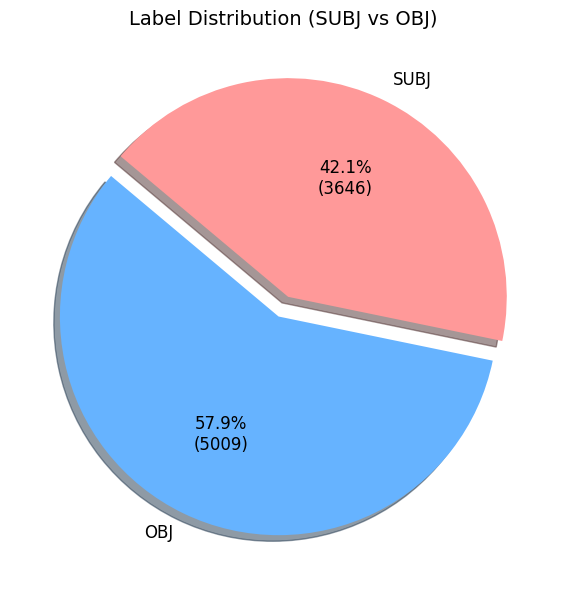

In [ ]:
import matplotlib.pyplot as plt

# colors and labels
labels = df_full['Label'].value_counts().index
sizes = df_full['Label'].value_counts().values
colors = ['#66b3ff', '#ff9999']  # Custom pastel colors
explode = (0.05, 0.05)  # Slightly "explode" both slices for emphasis

# custom label formatter
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100.*sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

# pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda pct: autopct_format(pct, sizes),
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12}
)

plt.title('Label Distribution (SUBJ vs OBJ)', fontsize=14)
plt.tight_layout()
plt.show()


In [11]:
from collections import Counter
import re
# Cleaning Data [Remove unncessary symbols]
def cleaning_documents(articles):
      path = '/kaggle/input/bengali-stopwords/bangla_stopwords.txt'
      news = articles.replace('\n',' ')
      news = re.sub('[^\u0980-\u09FF]',' ',str(news)) #removing unnecessary punctuation
      # stopwords removal
      stp = open(path,'r',encoding='utf-8').read().split()
      result = news.split()
      news = [word.strip() for word in result if word not in stp ]
      news =" ".join(news)
      return news

train_df['cleanedText'] = train_df['Text'].apply(cleaning_documents)
val_df['cleanedText']   = val_df['Text'].apply(cleaning_documents)
test_df['cleanedText']  = test_df['Text'].apply(cleaning_documents)

In [12]:
train_df

,Id,Text,Label,Annotation0,Annotation1,Annotation2,Source,Date,Source Link,cleanedText
0,5499,জেলে বসেই যখন তারা অপরাধজগৎ নিয়ন্ত্রণ করতে পের...,OBJ,OBJ,OBJ,OBJ,Prothomalo,28/02/2025,https://www.prothomalo.com/opinion/column/4gmt...,জেলে বসেই অপরাধজগৎ নিয়ন্ত্রণ পেরেছে মুক্ত বাতা...
1,5901,বাংলাদেশ এখন ডেভেলপমেন্টের পথে হাঁটছে,SUBJ,SUBJ,SUBJ,SUBJ,Prothomalo,28/02/2025,https://www.prothomalo.com/opinion/column/dyov...,বাংলাদেশ ডেভেলপমেন্টের পথে হাঁটছে
2,7908,বিএনপির বর্ধিত সভায় দলীয় চেয়ারপারসন খালেদা জিয়...,SUBJ,SUBJ,SUBJ,SUBJ,Prothomalo,2025-11-03 00:00:00,https://www.prothomalo.com/opinion/column/ez64...,বিএনপির বর্ধিত সভায় দলীয় চেয়ারপারসন খালেদা জিয়...
3,2480,"প্রসঙ্গত, সরকারি তিতুমীর কলেজকে বিশ্ববিদ্যালয়ে...",OBJ,OBJ,OBJ,OBJ,Protidinersangbad,2025-03-02 00:00:00,https://www.protidinersangbad.com/education-pr...,প্রসঙ্গত সরকারি তিতুমীর কলেজকে বিশ্ববিদ্যালয়ে ...
4,2897,"রওনক জাহান বলেন, ছিনতাইয়ের ঘটনায় ইতালির ওই নাগ...",OBJ,OBJ,OBJ,OBJ,Prothomalo,2025-03-02 00:00:00,https://www.prothomalo.com/bangladesh/crime/tl...,রওনক জাহান ছিনতাইয়ের ঘটনায় ইতালির নাগরিক গতকাল...
...,...,...,...,...,...,...,...,...,...,...
6919,7899,এপ্রিল মাসে দলের বর্ধিত সভায় বক্তব্য প্রদান করেন,OBJ,OBJ,OBJ,OBJ,Prothomalo,2025-11-03 00:00:00,https://www.prothomalo.com/opinion/column/ez64...,এপ্রিল মাসে দলের বর্ধিত সভায় প্রদান
6920,2890,এতে স্বাস্থ্যঝুঁকিতে পড়েছে ৬টি ইউনিয়ন ও ১টি পৌ...,OBJ,OBJ,OBJ,OBJ,Prothomalo,2025-03-02 00:00:00,https://www.prothomalo.com/bangladesh/district...,স্বাস্থ্যঝুঁকিতে পড়েছে ৬টি ইউনিয়ন ১টি পৌরসভার ...
6921,2374,"মাইকেল কফম্যান বলেন, যুদ্ধজাহাজের রক্ষণাবেক্ষণ...",OBJ,OBJ,OBJ,OBJ,Prothomalo,2025-03-02 00:00:00,https://www.prothomalo.com/world/europe/6cvudl...,মাইকেল কফম্যান যুদ্ধজাহাজের রক্ষণাবেক্ষণ সেগুল...
6922,5307,এর মধ্যে সবচেয়ে গুরুত্বপূর্ণ হলো দেশের প্রতিটি...,SUBJ,SUBJ,SUBJ,SUBJ,Prothomalo,28/02/2025,https://www.prothomalo.com/opinion/column/f6tg...,সবচেয়ে গুরুত্বপূর্ণ দেশের প্রতিটি প্রদেশে উলাম...


In [13]:
#config
RANDOM_SEED = 42
MAX_FEATURES = 10000
MAX_ITER = 10000

In [14]:
train_df['Label'].value_counts()

Label
OBJ     4007
SUBJ    2917
Name: count, dtype: int64

In [15]:
#import 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def encode_labels(train_df, val_df, test_df):
    """
    Encodes the 'Label' column in train, val, and test DataFrames using LabelEncoder.
    Returns the updated DataFrames.
    """
    le = LabelEncoder()
    train_df['Label'] = le.fit_transform(train_df['Label'])
    val_df['Label']   = le.transform(val_df['Label'])
    test_df['Label']  = le.transform(test_df['Label'])
    return train_df, val_df, test_df


def prepare_datasets(train_df, val_df, test_df, transformerDL=True):
    """
    Extracts features and labels from the given DataFrames based on transformerDL flag.
    Returns: X_train, X_val, X_test, y_train, y_val, y_test
    """
    text_col = 'Text' if transformerDL else 'cleanedText'
    
    X_train = train_df[text_col]
    y_train = train_df['Label']
    
    X_val = val_df[text_col]
    y_val = val_df['Label']
    
    X_test = test_df[text_col]
    y_test = test_df['Label']
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    
# Encode labels
train_df, val_df, test_df = encode_labels(train_df, val_df, test_df)

# Prepare datasets
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(train_df, val_df, test_df, transformerDL=False)


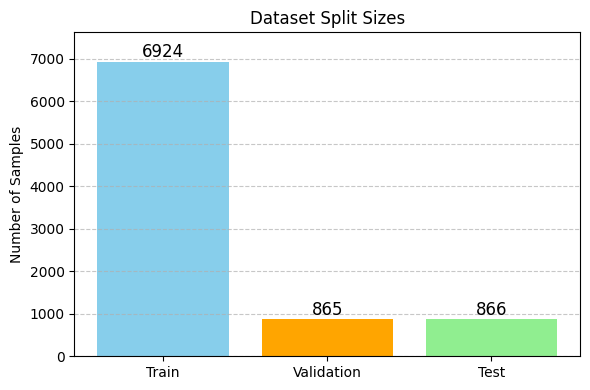

Train size: 6924
Val size:   865
Test size:  866


In [16]:
import matplotlib.pyplot as plt

# Sizes
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train', 'Validation', 'Test']
colors = ['skyblue', 'orange', 'lightgreen']

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, sizes, color=colors)

# Add value labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 10, f'{yval}', ha='center', va='bottom', fontsize=12)

# Labels and title
plt.ylabel("Number of Samples")
plt.title("Dataset Split Sizes")
plt.ylim(0, max(sizes) * 1.1)  # Add some padding above the tallest bar
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")



🔍 Using Vectorizer: TF-IDF
--------------------------------------------------

=== Model: Logistic R ===
              precision    recall  f1-score   support

         OBJ       0.76      0.85      0.81       501
        SUBJ       0.76      0.64      0.69       365

    accuracy                           0.76       866
   macro avg       0.76      0.74      0.75       866
weighted avg       0.76      0.76      0.76       866



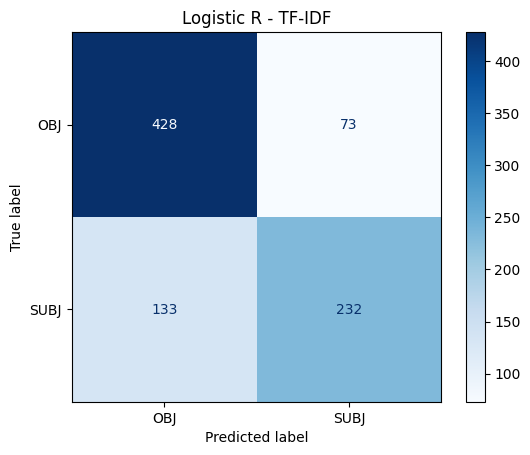


=== Model: SVM ===
              precision    recall  f1-score   support

         OBJ       0.80      0.82      0.81       501
        SUBJ       0.74      0.72      0.73       365

    accuracy                           0.78       866
   macro avg       0.77      0.77      0.77       866
weighted avg       0.78      0.78      0.78       866



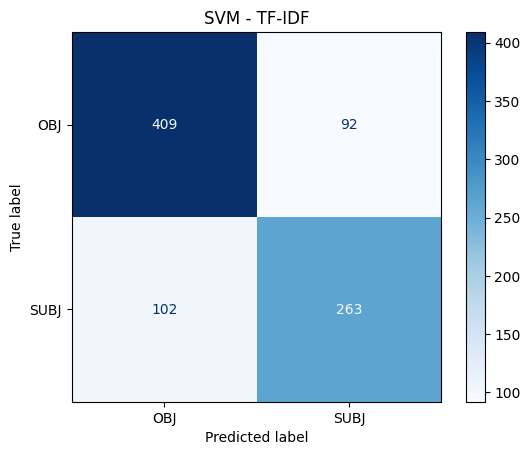


=== Model: Random F ===
              precision    recall  f1-score   support

         OBJ       0.76      0.77      0.76       501
        SUBJ       0.68      0.67      0.67       365

    accuracy                           0.73       866
   macro avg       0.72      0.72      0.72       866
weighted avg       0.73      0.73      0.73       866



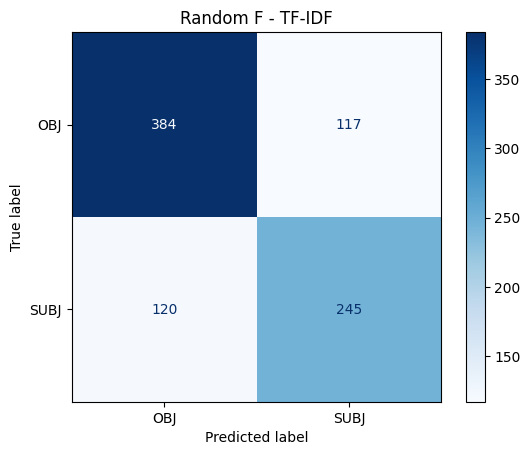


=== Model: Naive B ===
              precision    recall  f1-score   support

         OBJ       0.75      0.88      0.81       501
        SUBJ       0.78      0.60      0.68       365

    accuracy                           0.76       866
   macro avg       0.77      0.74      0.74       866
weighted avg       0.76      0.76      0.75       866



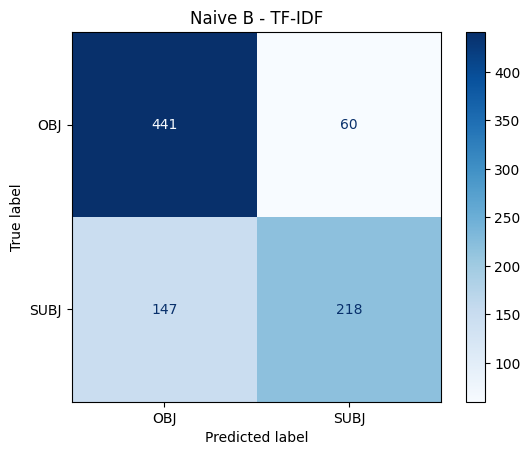


=== Model: XGBoost ===
              precision    recall  f1-score   support

         OBJ       0.72      0.80      0.76       501
        SUBJ       0.68      0.58      0.63       365

    accuracy                           0.71       866
   macro avg       0.70      0.69      0.69       866
weighted avg       0.71      0.71      0.70       866



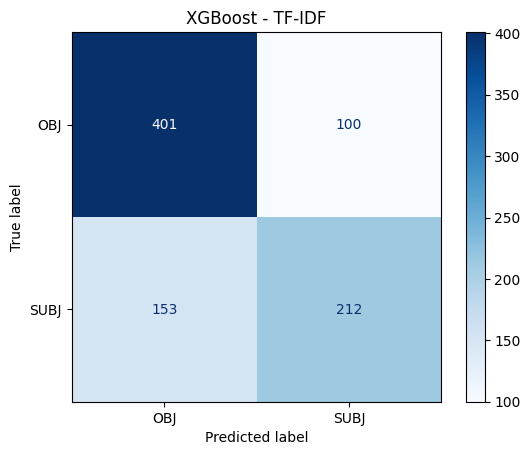


=== Model: Ensemble ===
              precision    recall  f1-score   support

         OBJ       0.76      0.85      0.80       501
        SUBJ       0.76      0.63      0.69       365

    accuracy                           0.76       866
   macro avg       0.76      0.74      0.75       866
weighted avg       0.76      0.76      0.76       866



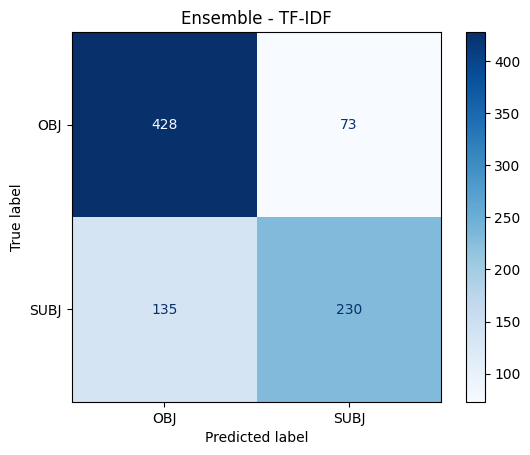



🔍 Using Vectorizer: CountVec
--------------------------------------------------

=== Model: Logistic R ===
              precision    recall  f1-score   support

         OBJ       0.78      0.82      0.80       501
        SUBJ       0.73      0.69      0.71       365

    accuracy                           0.76       866
   macro avg       0.76      0.75      0.75       866
weighted avg       0.76      0.76      0.76       866



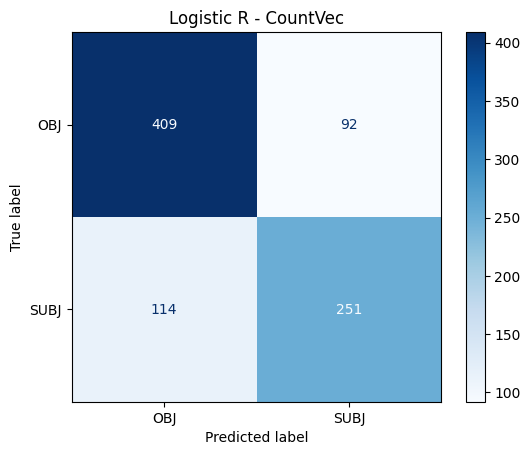


=== Model: SVM ===
              precision    recall  f1-score   support

         OBJ       0.79      0.78      0.78       501
        SUBJ       0.70      0.71      0.71       365

    accuracy                           0.75       866
   macro avg       0.75      0.75      0.75       866
weighted avg       0.75      0.75      0.75       866



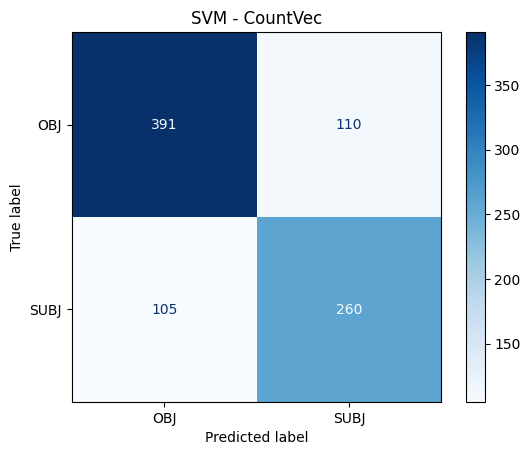


=== Model: Random F ===
              precision    recall  f1-score   support

         OBJ       0.77      0.76      0.77       501
        SUBJ       0.68      0.69      0.68       365

    accuracy                           0.73       866
   macro avg       0.73      0.73      0.73       866
weighted avg       0.73      0.73      0.73       866



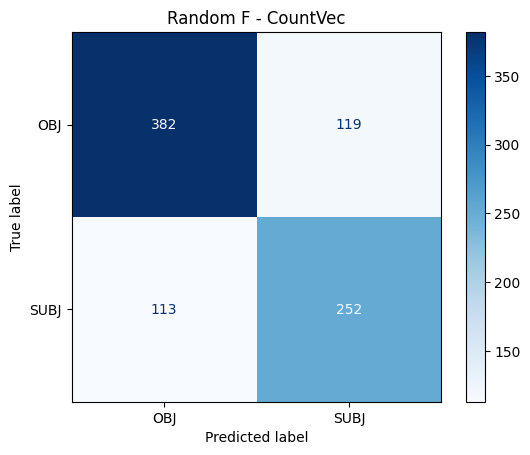


=== Model: Naive B ===
              precision    recall  f1-score   support

         OBJ       0.79      0.79      0.79       501
        SUBJ       0.71      0.70      0.71       365

    accuracy                           0.76       866
   macro avg       0.75      0.75      0.75       866
weighted avg       0.75      0.76      0.76       866



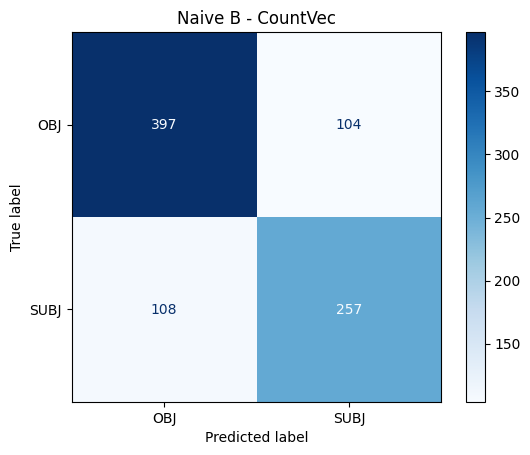


=== Model: XGBoost ===
              precision    recall  f1-score   support

         OBJ       0.72      0.82      0.77       501
        SUBJ       0.70      0.57      0.63       365

    accuracy                           0.72       866
   macro avg       0.71      0.70      0.70       866
weighted avg       0.71      0.72      0.71       866



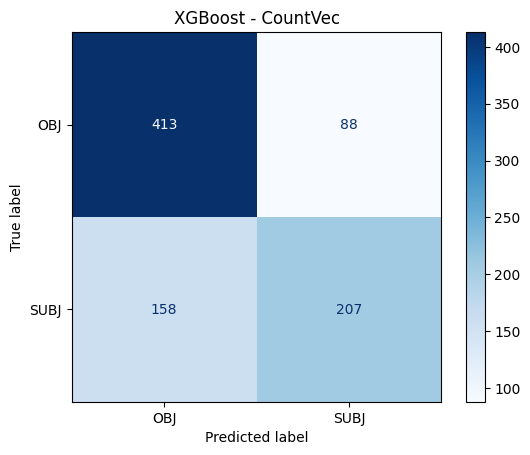


=== Model: Ensemble ===
              precision    recall  f1-score   support

         OBJ       0.78      0.83      0.81       501
        SUBJ       0.75      0.68      0.71       365

    accuracy                           0.77       866
   macro avg       0.77      0.76      0.76       866
weighted avg       0.77      0.77      0.77       866



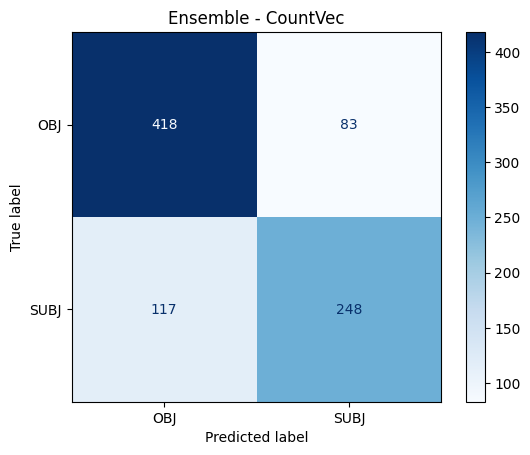



🔍 Using Vectorizer: HashingVec
--------------------------------------------------

=== Model: Logistic R ===
              precision    recall  f1-score   support

         OBJ       0.72      0.82      0.77       501
        SUBJ       0.70      0.57      0.63       365

    accuracy                           0.72       866
   macro avg       0.71      0.70      0.70       866
weighted avg       0.71      0.72      0.71       866



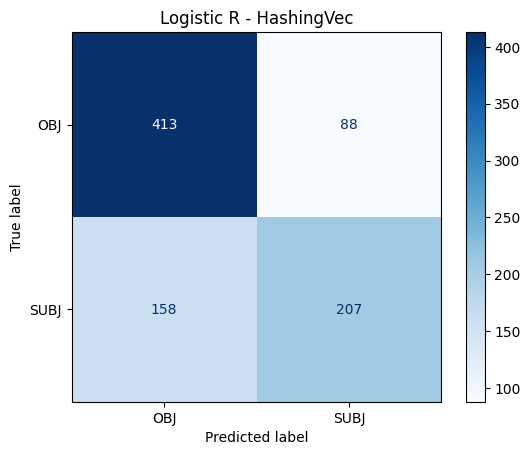


=== Model: SVM ===
              precision    recall  f1-score   support

         OBJ       0.76      0.79      0.77       501
        SUBJ       0.69      0.67      0.68       365

    accuracy                           0.74       866
   macro avg       0.73      0.73      0.73       866
weighted avg       0.73      0.74      0.73       866



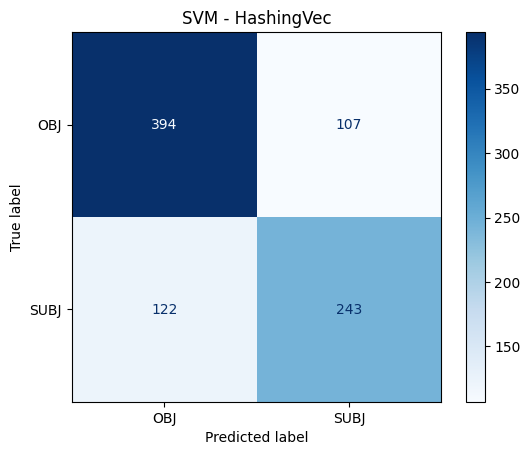


=== Model: Random F ===
              precision    recall  f1-score   support

         OBJ       0.74      0.79      0.76       501
        SUBJ       0.68      0.61      0.64       365

    accuracy                           0.71       866
   macro avg       0.71      0.70      0.70       866
weighted avg       0.71      0.71      0.71       866



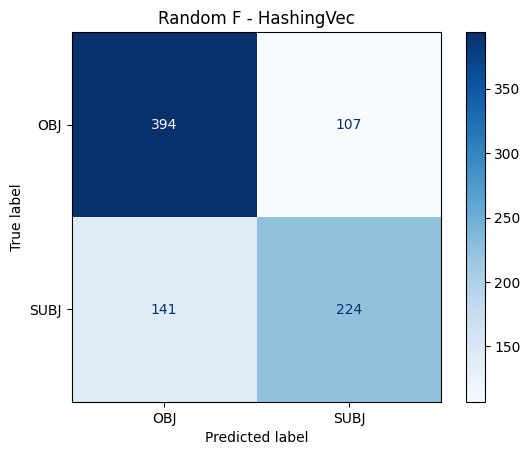


=== Model: Naive B ===
              precision    recall  f1-score   support

         OBJ       0.68      0.91      0.78       501
        SUBJ       0.77      0.40      0.52       365

    accuracy                           0.70       866
   macro avg       0.72      0.65      0.65       866
weighted avg       0.71      0.70      0.67       866



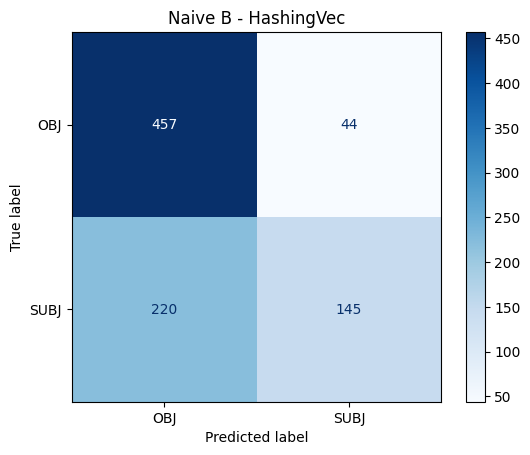


=== Model: XGBoost ===
              precision    recall  f1-score   support

         OBJ       0.71      0.83      0.76       501
        SUBJ       0.69      0.54      0.61       365

    accuracy                           0.71       866
   macro avg       0.70      0.68      0.69       866
weighted avg       0.70      0.71      0.70       866



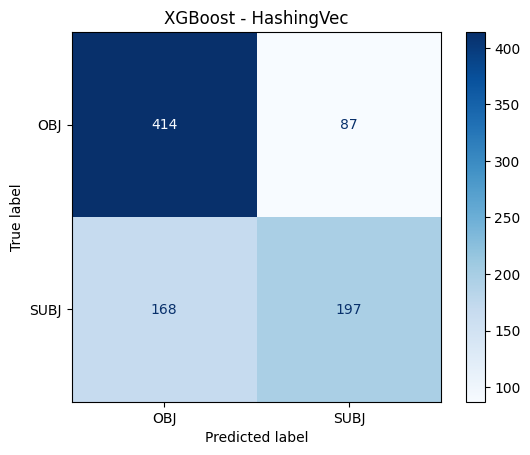


=== Model: Ensemble ===
              precision    recall  f1-score   support

         OBJ       0.72      0.85      0.78       501
        SUBJ       0.72      0.54      0.62       365

    accuracy                           0.72       866
   macro avg       0.72      0.69      0.70       866
weighted avg       0.72      0.72      0.71       866



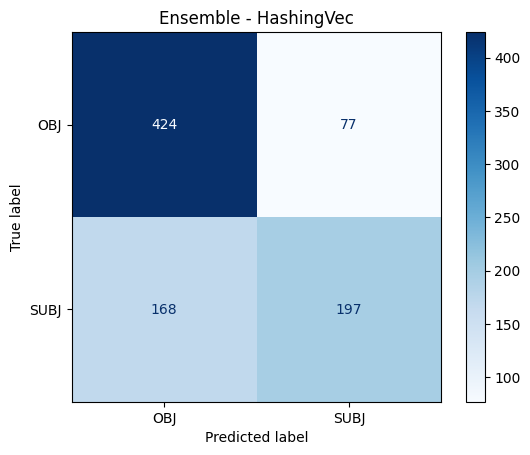


=== All Model Results ===
    Vectorizer       Model  Accuracy  Precision    Recall  F1 Score
1       TF-IDF         SVM  0.775982   0.740845  0.720548  0.730556
11    CountVec    Ensemble  0.769053   0.749245  0.679452  0.712644
6     CountVec  Logistic R  0.762125   0.731778  0.687671  0.709040
9     CountVec     Naive B  0.755196   0.711911  0.704110  0.707989
7     CountVec         SVM  0.751732   0.702703  0.712329  0.707483
0       TF-IDF  Logistic R  0.762125   0.760656  0.635616  0.692537
5       TF-IDF    Ensemble  0.759815   0.759076  0.630137  0.688623
8     CountVec    Random F  0.732102   0.679245  0.690411  0.684783
13  HashingVec         SVM  0.735566   0.694286  0.665753  0.679720
3       TF-IDF     Naive B  0.760970   0.784173  0.597260  0.678072
2       TF-IDF    Random F  0.726328   0.676796  0.671233  0.674003
14  HashingVec    Random F  0.713626   0.676737  0.613699  0.643678
12  HashingVec  Logistic R  0.715935   0.701695  0.567123  0.627273
10    CountVec     XG

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

vectorizers = {
    "TF-IDF": TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1, 2)),
    "CountVec": CountVectorizer(max_features=MAX_FEATURES, ngram_range=(1, 2)),
    "HashingVec": HashingVectorizer(n_features=MAX_FEATURES, alternate_sign=False)
}
models = {
    "Logistic R": LogisticRegression(max_iter=MAX_ITER),
    "SVM": LinearSVC(),
    "Random F": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    "Naive B": MultinomialNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('Logistic R', LogisticRegression(max_iter=MAX_ITER)),
        ('SVM', LinearSVC()),
        ('Random F', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)),
        ('Naive B', MultinomialNB()),
        ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ],
    voting='hard' 
)
models["Ensemble"] = ensemble_model

all_results = []

for vec_name, vectorizer in vectorizers.items():
    print(f"\n\n🔍 Using Vectorizer: {vec_name}\n{'-'*50}")

    # Transform text data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for model_name, model in models.items():
        print(f"\n=== Model: {model_name} ===")

        # Train model
        model.fit(X_train_vec, y_train)

        # Predict
        y_pred = model.predict(X_test_vec)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Classification Report
        print(classification_report(y_test, y_pred, target_names=['OBJ', 'SUBJ']))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['OBJ', 'SUBJ'])
        disp.plot(cmap='Blues')
        plt.title(f"{model_name} - {vec_name}")
        plt.show()

        all_results.append({
            "Vectorizer": vec_name,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1
        })
#res
results_df = pd.DataFrame(all_results).sort_values(by='F1 Score', ascending=False)
print("\n=== All Model Results ===")
print(results_df)
